In [1]:
# CELL 1: Imports and Configuration
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import re
import pickle
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
IMAGE_DIR = '/kaggle/input/flickr8k/Flickr8k_Dataset'
print("Imports and configuration complete")
CAPTION_FILE = '/kaggle/input/flickr8k/Flickr8k_text/Flickr8k.token.txt'
VOCAB_SIZE = 5000  # Reduced from 8000
EMBEDDING_DIM = 128  # Reduced from 256
UNITS = 128  # Reduced from 256
BATCH_SIZE = 32  # Reduced from 64
EPOCHS = 5  # Reduced from 10

# KEY CHANGE: Using only a subset of images -cus of kernel crash-
USE_SUBSET = True
SUBSET_SIZE = 1000  # Use only 1000 images instead of 8092

print("Fast training configuration loaded")
print(f"  Using subset: {SUBSET_SIZE} images")

2026-02-09 20:16:24.842362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770668185.218534      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770668185.352585      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770668186.249906      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770668186.249948      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770668186.249951      24 computation_placer.cc:177] computation placer alr

Imports and configuration complete
Fast training configuration loaded
  Using subset: 1000 images


In [2]:
# ============================================================================
# CELL 2: Load Captions (keep your function)
def load_flickr8k_caption(caption_file_path):
    caption_image = {}
    with open(caption_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            image_part, caption = line.split('\t')
            image_name = image_part.split('#')[0]
            caption = caption.strip()
            if image_name not in caption_image:
                caption_image[image_name] = []
            caption_image[image_name].append(caption)
    return caption_image

res = load_flickr8k_caption(CAPTION_FILE)
print(f"Loaded {len(res)} total images")

# USE SUBSET
if USE_SUBSET:
    all_images = list(res.keys())
    np.random.seed(42)
    subset_images = np.random.choice(all_images, SUBSET_SIZE, replace=False)
    res = {img: res[img] for img in subset_images}
    print(f"Using subset of {len(res)} images")


Loaded 8092 total images
Using subset of 1000 images


In [3]:
# ============================================================================
# CELL 3: Preprocessing Functions
def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r"\s+", ' ', text)
    return text.strip()

def add_special_tokens(caption):
    return "<start> " + caption + " <end>"

def preprocess_captions(samples):
    processed = []
    for img_path, caption in samples:
        caption = clean_caption(caption)
        caption = add_special_tokens(caption)
        processed.append((img_path, caption))
    return processed

print("Preprocessing functions defined")

Preprocessing functions defined


In [4]:
# ============================================================================
# CELL 4: Build Samples
def build_sample(image_names, caption_mapping, image_dir):
    sample = []
    missing = 0
    
    for image_name in image_names:
        if image_name not in caption_mapping:
            continue
        
        image_path = os.path.join(image_dir, image_name)
        
        if not os.path.exists(image_path):
            missing += 1
            continue
        
        for caption in caption_mapping[image_name]:
            sample.append((str(image_path), caption))
    
    if missing > 0:
        print(f"  Skipped {missing} missing files")
    
    return sample

# Split data
image_ids = list(res.keys())
train_img, temp_img = train_test_split(image_ids, test_size=0.2, random_state=42)
test_img, val_img = train_test_split(temp_img, test_size=0.5, random_state=42)

print(f"Data split:")
print(f"  Train: {len(train_img)} images")
print(f"  Val:   {len(val_img)} images")
print(f"  Test:  {len(test_img)} images")

# Build samples
train_sample = build_sample(train_img, res, IMAGE_DIR)
val_sample = build_sample(val_img, res, IMAGE_DIR)
test_sample = build_sample(test_img, res, IMAGE_DIR)

print(f"\nSamples created:")
print(f"  Train: {len(train_sample)} samples")
print(f"  Val:   {len(val_sample)} samples")

# Preprocess
train_sample_p = preprocess_captions(train_sample)
val_sample_p = preprocess_captions(val_sample)


Data split:
  Train: 800 images
  Val:   100 images
  Test:  100 images
  Skipped 1 missing files

Samples created:
  Train: 3995 samples
  Val:   500 samples


In [5]:
# ============================================================================
# CELL 5: Image Processing & CNN Encoder
def load_and_preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

print("Loading ResNet50...")
cnn_encoder = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False
)
cnn_encoder.trainable = False
print("ResNet50 loaded")

Loading ResNet50...


I0000 00:00:1770668210.319862      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770668210.326361      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 loaded


In [6]:
# ============================================================================
# CELL 6: Extract Features (MUCH FASTER with subset)
def cache_features_fast(samples, cache_path):
    """Extract features with progress display"""
    feature_cache = {}
    
    print(f"Extracting features from {len(samples)} samples...")
    
    for idx, (img_path, caption) in enumerate(samples):
        if img_path not in feature_cache:
            try:
                image = load_and_preprocess(img_path)
                image = tf.expand_dims(image, axis=0)
                feature = cnn_encoder(image)
                feature_cache[img_path] = tf.squeeze(feature, axis=0).numpy()
            except:
                continue
        
        # Progress every 200 samples
        if (idx + 1) % 200 == 0:
            print(f"  {idx+1}/{len(samples)} completed...")
    
    with open(cache_path, 'wb') as f:
        pickle.dump(feature_cache, f)
    
    print(f"Extracted {len(feature_cache)} features")
    return feature_cache

# Extract features -used t take loooonger-
if os.path.exists('train_features_small.pkl'):
    print("Loading cached features...")
    with open('train_features_small.pkl', 'rb') as f:
        train_features = pickle.load(f)
    with open('val_features_small.pkl', 'rb') as f:
        val_features = pickle.load(f)
else:
    train_features = cache_features_fast(train_sample_p, 'train_features_small.pkl')
    val_features = cache_features_fast(val_sample_p, 'val_features_small.pkl')

Extracting features from 3995 samples...


I0000 00:00:1770668214.017160      24 cuda_dnn.cc:529] Loaded cuDNN version 91002


  200/3995 completed...
  400/3995 completed...
  600/3995 completed...
  800/3995 completed...
  1000/3995 completed...
  1200/3995 completed...
  1400/3995 completed...
  1600/3995 completed...
  1800/3995 completed...
  2000/3995 completed...
  2200/3995 completed...
  2400/3995 completed...
  2600/3995 completed...
  2800/3995 completed...
  3000/3995 completed...
  3200/3995 completed...
  3400/3995 completed...
  3600/3995 completed...
  3800/3995 completed...
Extracted 799 features
Extracting features from 500 samples...
  200/500 completed...
  400/500 completed...
Extracted 100 features


In [7]:
# ============================================================================
# CELL 7: Prepare Sequences
train_captions = [cap for _, cap in train_sample_p]
val_captions = [cap for _, cap in val_sample_p]

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters="")
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = min(len(tokenizer.word_index) + 1, VOCAB_SIZE)
max_length = max(len(cap.split()) for cap in train_captions)

print(f"Tokenizer ready")
print(f"  Vocab size: {vocab_size}")
print(f"  Max length: {max_length}")

train_seqs = tokenizer.texts_to_sequences(train_captions)
val_seqs = tokenizer.texts_to_sequences(val_captions)

train_seqs = pad_sequences(train_seqs, maxlen=max_length, padding='post')
val_seqs = pad_sequences(val_seqs, maxlen=max_length, padding='post')

train_img_paths = [img_path for img_path, _ in train_sample_p]
val_img_paths = [img_path for img_path, _ in val_sample_p]

train_features_array = np.array([train_features[path] for path in train_img_paths])
val_features_array = np.array([val_features[path] for path in val_img_paths])

train_inputs = train_seqs[:, :-1]
train_targets = train_seqs[:, 1:]
val_inputs = val_seqs[:, :-1]
val_targets = val_seqs[:, 1:]

print(f"Data ready for training")
print(f"  Features: {train_features_array.shape}")
print(f"  Sequences: {train_inputs.shape}")

Tokenizer ready
  Vocab size: 2873
  Max length: 33
Data ready for training
  Features: (3995, 7, 7, 2048)
  Sequences: (3995, 32)


In [8]:
# ============================================================================
# CELL 8: Model Building Functions
def build_rnn_model(vocab_size, max_length, units=128):
    input_img = layers.Input(shape=(7, 7, 2048))
    img_flat = layers.Flatten()(input_img)
    img_dense = layers.Dense(units, activation='relu')(img_flat)
    
    input_caption = layers.Input(shape=(max_length-1,))
    caption_embed = layers.Embedding(vocab_size, units, mask_zero=True)(input_caption)
    caption_rnn = layers.SimpleRNN(units, return_sequences=True)(caption_embed)
    
    img_repeat = layers.RepeatVector(max_length-1)(img_dense)
    merged = layers.Add()([img_repeat, caption_rnn])
    merged = layers.Dense(units, activation='relu')(merged)
    output = layers.Dense(vocab_size, activation='softmax')(merged)
    
    return keras.Model(inputs=[input_img, input_caption], outputs=output)

def build_lstm_model(vocab_size, max_length, units=128):
    input_img = layers.Input(shape=(7, 7, 2048))
    img_flat = layers.Flatten()(input_img)
    img_dense = layers.Dense(units, activation='relu')(img_flat)
    
    input_caption = layers.Input(shape=(max_length-1,))
    caption_embed = layers.Embedding(vocab_size, units, mask_zero=True)(input_caption)
    caption_lstm = layers.LSTM(units, return_sequences=True)(caption_embed)
    caption_dropout = layers.Dropout(0.5)(caption_lstm)
    
    img_repeat = layers.RepeatVector(max_length-1)(img_dense)
    merged = layers.Add()([img_repeat, caption_dropout])
    merged = layers.Dense(units, activation='relu')(merged)
    output = layers.Dense(vocab_size, activation='softmax')(merged)
    
    return keras.Model(inputs=[input_img, input_caption], outputs=output)

def build_transformer_model(vocab_size, max_length, d_model=128, num_heads=4):
    input_img = layers.Input(shape=(7, 7, 2048))
    img_flat = layers.Flatten()(input_img)
    img_dense = layers.Dense(d_model, activation='relu')(img_flat)
    img_expand = layers.Reshape((1, d_model))(img_dense)
    
    input_caption = layers.Input(shape=(max_length-1,))
    caption_embed = layers.Embedding(vocab_size, d_model, mask_zero=True)(input_caption)
    
    positions = tf.range(start=0, limit=max_length-1, delta=1)
    pos_embed = layers.Embedding(max_length, d_model)(positions)
    caption_embed = caption_embed + pos_embed
    
    combined = layers.Concatenate(axis=1)([img_expand, caption_embed])
    
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model//num_heads
    )(combined, combined)
    attn_output = layers.Dropout(0.1)(attn_output)
    x = layers.LayerNormalization()(combined + attn_output)
    
    ffn = keras.Sequential([
        layers.Dense(256, activation='relu'),
        layers.Dense(d_model)
    ])
    ffn_output = ffn(x)
    ffn_output = layers.Dropout(0.1)(ffn_output)
    x = layers.LayerNormalization()(x + ffn_output)
    
    x = x[:, 1:, :]
    output = layers.Dense(vocab_size, activation='softmax')(x)
    
    return keras.Model(inputs=[input_img, input_caption], outputs=output)

print("Model functions defined")

Model functions defined


In [9]:
# ============================================================================
# CELL 9: Build Models
print("\n" + "="*60)
print("BUILDING MODELS")
print("="*60)

rnn_model = build_rnn_model(vocab_size, max_length, UNITS)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(f"RNN: {rnn_model.count_params():,} parameters")

lstm_model = build_lstm_model(vocab_size, max_length, UNITS)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(f"LSTM: {lstm_model.count_params():,} parameters")

transformer_model = build_transformer_model(vocab_size, max_length, UNITS, num_heads=4)
transformer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(f"Transformer: {transformer_model.count_params():,} parameters")


BUILDING MODELS
RNN: 13,632,953 parameters
LSTM: 13,731,641 parameters
Transformer: 13,716,025 parameters


In [10]:
# ============================================================================
# CELL 10: Train Models (FAST - only 5 epochs each)
histories = {}
training_times = {}

print("\n" + "="*60)
print("TRAINING RNN")
print("="*60)
start = time.time()
histories['RNN'] = rnn_model.fit(
    [train_features_array, train_inputs], train_targets,
    validation_data=([val_features_array, val_inputs], val_targets),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)
training_times['RNN'] = time.time() - start
print(f"RNN done in {training_times['RNN']/60:.1f} min")

print("\n" + "="*60)
print("TRAINING LSTM")
print("="*60)
start = time.time()
histories['LSTM'] = lstm_model.fit(
    [train_features_array, train_inputs], train_targets,
    validation_data=([val_features_array, val_inputs], val_targets),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)
training_times['LSTM'] = time.time() - start
print(f"LSTM done in {training_times['LSTM']/60:.1f} min")

print("\n" + "="*60)
print("TRAINING TRANSFORMER")
print("="*60)
start = time.time()
histories['Transformer'] = transformer_model.fit(
    [train_features_array, train_inputs], train_targets,
    validation_data=([val_features_array, val_inputs], val_targets),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)
training_times['Transformer'] = time.time() - start
print(f"Transformer done in {training_times['Transformer']/60:.1f} min")



TRAINING RNN
Epoch 1/5


I0000 00:00:1770668413.120839      68 service.cc:152] XLA service 0x7cebac005f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770668413.120879      68 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770668413.120885      68 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 15/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3561 - loss: 9.8935 

I0000 00:00:1770668415.626424      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5519 - loss: 5.0093 - val_accuracy: 0.6837 - val_loss: 2.0439
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6946 - loss: 1.9095 - val_accuracy: 0.6924 - val_loss: 1.9320
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7070 - loss: 1.7116 - val_accuracy: 0.7137 - val_loss: 1.7956
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7310 - loss: 1.5011 - val_accuracy: 0.7228 - val_loss: 1.7185
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7377 - loss: 1.4021 - val_accuracy: 0.7244 - val_loss: 1.6930
RNN done in 0.4 min

TRAINING LSTM
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5679 - loss: 4.2149 - val_accuracy: 0.6662 - val_loss: 2.0812
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6745 - loss: 1.9214 - val_accuracy: 0.6743 - val_loss: 2.0369
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6832 - loss:

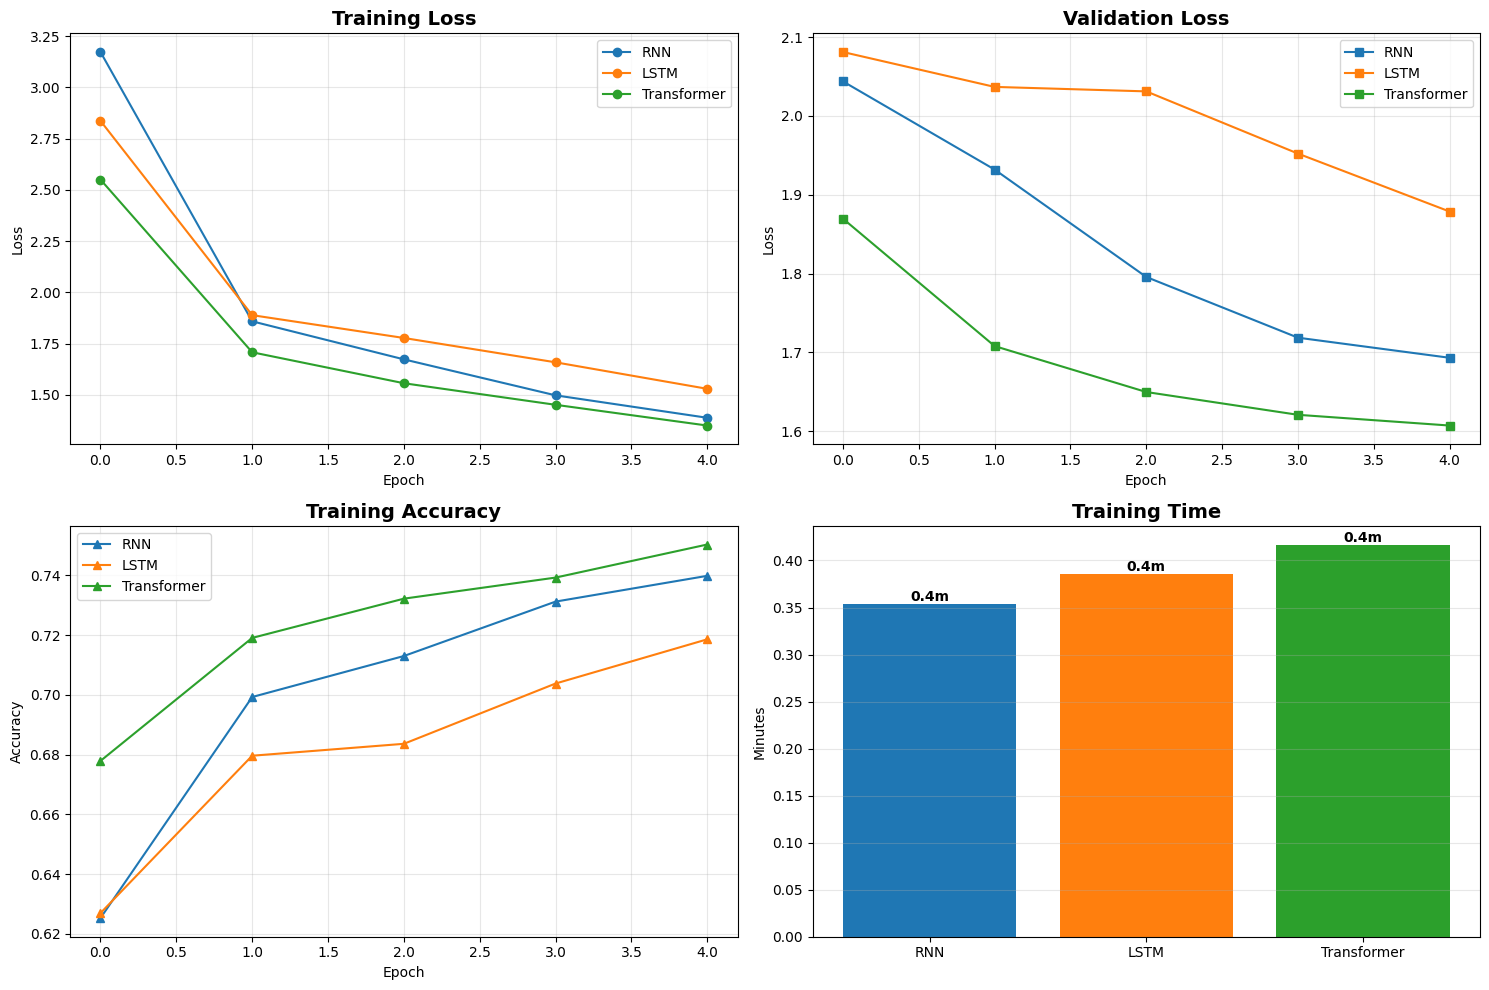

In [11]:
# ============================================================================
# CELL 11: Visualize Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for name, history in histories.items():
    axes[0, 0].plot(history.history['loss'], label=name, marker='o')
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

for name, history in histories.items():
    axes[0, 1].plot(history.history['val_loss'], label=name, marker='s')
axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

for name, history in histories.items():
    axes[1, 0].plot(history.history['accuracy'], label=name, marker='^')
axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

names = list(training_times.keys())
times = [training_times[name] / 60 for name in names]
bars = axes[1, 1].bar(names, times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_title('Training Time', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Minutes')
axes[1, 1].grid(True, axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}m', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# ============================================================================
# CELL 12: Results Summary
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"{'Model':<15} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12} {'Time (min)':<12}")
print("-"*80)

for name in ['RNN', 'LSTM', 'Transformer']:
    train_loss = histories[name].history['loss'][-1]
    val_loss = histories[name].history['val_loss'][-1]
    train_acc = histories[name].history['accuracy'][-1] * 100
    val_acc = histories[name].history['val_accuracy'][-1] * 100
    time_min = training_times[name] / 60
    print(f"{name:<15} {train_loss:<12.4f} {val_loss:<12.4f} {train_acc:<12.2f}% {val_acc:<12.2f}% {time_min:<12.2f}")

print("="*80)



FINAL RESULTS
Model           Train Loss   Val Loss     Train Acc    Val Acc      Time (min)  
--------------------------------------------------------------------------------
RNN             1.3887       1.6930       73.99       % 72.44       % 0.35        
LSTM            1.5299       1.8786       71.86       % 70.81       % 0.39        
Transformer     1.3508       1.6070       75.04       % 72.43       % 0.42        


In [13]:
# CELL 13: Generate Sample Captions - CORRECTED
def generate_caption(model, image_features, tokenizer, max_length, temperature=0.7):
    feature = np.expand_dims(image_features, 0)
    start_token = tokenizer.word_index.get('<start>', 1)
    end_token = tokenizer.word_index.get('<end>', 2)
    caption = [start_token]  # Initialize as list
    
    for i in range(max_length - 1):
        sequence = pad_sequences([caption], maxlen=max_length-1, padding='post')
        predictions = model.predict([feature, sequence], verbose=0)
        
        current_pos = min(len(caption) - 1, predictions.shape[1] - 1)
        probs = predictions[0, current_pos, :]  # Get probs
        
        # Temperature sampling
        probs = np.log(probs + 1e-8) / temperature
        probs = np.exp(probs) / np.sum(np.exp(probs))
        predicted_id = np.random.choice(len(probs), p=probs)
        
        if predicted_id == end_token or predicted_id == 0:
            break
        
        caption.append(predicted_id)
    
    words = [tokenizer.index_word.get(idx, '') for idx in caption[1:]]
    return ' '.join(words).strip()

print("\n" + "="*80)
print("SAMPLE CAPTIONS")
print("="*80)

for i in range(min(5, len(val_img_paths))):
    print(f"\nImage {i+1}: {os.path.basename(val_img_paths[i])}")
    print(f"Actual:      {val_captions[i]}")
    
    feature = val_features_array[i]
    
    try:
        rnn_cap = generate_caption(rnn_model, feature, tokenizer, max_length,  temperature=0.7)
        print(f"RNN:         {rnn_cap}")
    except Exception as e:
        print(f"RNN:         [Error: {e}]")
    
    try:
        lstm_cap = generate_caption(lstm_model, feature, tokenizer, max_length,  temperature=0.7)
        print(f"LSTM:        {lstm_cap}")
    except Exception as e:
        print(f"LSTM:        [Error: {e}]")
    
    try:
        trans_cap = generate_caption(transformer_model, feature, tokenizer, max_length,  temperature=0.7)
        print(f"Transformer: {trans_cap}")
    except Exception as e:
        print(f"Transformer: [Error: {e}]")
    
    print("-"*80)


SAMPLE CAPTIONS

Image 1: 3036641436_d6594fc45f.jpg
Actual:      <start> a boy sits between two girls on a swing <end>
RNN:         a kids with a boys and a player in the camera
LSTM:        two children while front wearing two reflective
Transformer: two women are in a white are robes and a concert an background
--------------------------------------------------------------------------------

Image 2: 3036641436_d6594fc45f.jpg
Actual:      <start> three children in blue shirts swinging on a swing set <end>
RNN:         two men playing carrying a ball
LSTM:        a building at a play
Transformer: two men in the man is standing in a bathing a man in a bride in the sidewalk
--------------------------------------------------------------------------------

Image 3: 3036641436_d6594fc45f.jpg
Actual:      <start> three people on swings <end>
RNN:         two man are in another smokes in a surf
LSTM:        three children in another of their leggings
Transformer: a sumo children in the fron